In [94]:
%load_ext autoreload
import glob
import nibabel 
import nilearn
import pandas as pd
import numpy as np
import h5py
from collections import defaultdict, Counter
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook, tqdm
from joblib import Parallel, delayed
import logging
from IPython.core.debugger import set_trace
from sklearn.model_selection import train_test_split

import re
import os
import shutil
import pickle

import torch
import torch.nn.functional as F

from utils import create_dicts, normalize, load, video, video_comparison

from multiprocessing import cpu_count
N_CPU = cpu_count()

from IPython.core.display import display, HTML
from celluloid import Camera

SEED = 42
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
import torchio

In [2]:
labels_components = np.load('metadata/label_info.npy', allow_pickle=True).item()
nonsingle_component_keys = {k for k,v in labels_components.items() if len(v['cc3d'][0]) != 2}

labels_broken = {'55','54', '47','43','37','33','25','12', '9','6','3','70NS','73NS', '73NS',
                  'n42','n30', 'n27', 'n31', 'n20', 'n10', 'n8', 'n3',
                 }.union(nonsingle_component_keys)

len(labels_broken)

34

In [93]:
labels_components

defaultdict(dict,
            {'n12': {'cc3d': [array([0, 1], dtype=uint16),
               array([16610130,     1036])],
              'd_s': [17, 14, 15],
              'center': array([156, 184, 132])},
             'G371': {'cc3d': [array([0, 1], dtype=uint16),
               array([17439499,     1912])],
              'd_s': [19, 12, 22],
              'center': array([153, 130, 186])},
             'n37': {'cc3d': [array([0, 1], dtype=uint16),
               array([17439008,     2403])],
              'd_s': [22, 19, 14],
              'center': array([80, 74, 84])},
             '33': {'cc3d': [array([0, 1], dtype=uint16),
               array([22912125,     4083])],
              'd_s': [43, 21, 21],
              'center': array([136,  53, 132])},
             'G177': {'cc3d': [array([0, 1], dtype=uint16),
               array([17440629,      782])],
              'd_s': [10, 13, 17],
              'center': array([166, 170,  42])},
             'n25': {'cc3d': [array([0, 1], 

# Original (w/o affine)

In [3]:
# root = '/media/tom/ibulygin/fcd_data/radiologist/'
# root_label = os.path.join(root, 'label')

# feature_paths_templates = {
#       'label':os.path.join(root,'label_orig/{label}.nii.gz'),
#       'mask':[os.path.join(root, 'fmriprep/sub-{label}/anat/*T1MprageSagP2Iso_desc-brain_mask.nii.gz'),
#              os.path.join(root, 'fmriprep/sub-{label}/anat/*T1MprNsSagP2Iso08Mm_desc-brain_mask.nii.gz'),
#              os.path.join(root, 'fmriprep/sub-{label}/anat/*Mprage_desc-brain_mask.nii.gz'),
#              os.path.join(root, 'fmriprep/sub-{label}/anat/*SagT1Mprage08MmIsoP2Fov256_desc-brain_mask.nii.gz'),
#              os.path.join(root, 'fmriprep/sub-{label}/anat/*T1MprageSagP2IsoOrig_desc-brain_mask.nii.gz'),
#              os.path.join(root, 'fmriprep/sub-{label}/anat/*T1MprageTraP2Iso_desc-brain_mask.nii.gz'),
#              os.path.join(root, 'fmriprep/sub-{label}/anat/*IrCorHiRes_desc-brain_mask.nii.gz'),
#               ],
#       'T1w':[os.path.join(root, 'fmriprep/sub-{label}/anat/*T1MprageSagP2Iso_desc-preproc_T1w.nii.gz'),
#             os.path.join(root, 'fmriprep/sub-{label}/anat/*T1MprNsSagP2Iso08Mm_desc-preproc_T1w.nii.gz'),
#             os.path.join(root, 'fmriprep/sub-{label}/anat/*Mprage_desc-preproc_T1w.nii.gz'),
#             os.path.join(root, 'fmriprep/sub-{label}/anat/*SagT1Mprage08MmIsoP2Fov256_desc-preproc_T1w.nii.gz'),
#             os.path.join(root, 'fmriprep/sub-{label}/anat/*T1MprageSagP2IsoOrig_desc-preproc_T1w.nii.gz'),
#             os.path.join(root, 'fmriprep/sub-{label}/anat/*T1MprageTraP2Iso_desc-preproc_T1w.nii.gz'),
#             os.path.join(root, 'fmriprep/sub-{label}/anat/*acq-IrCorHiRes_desc-preproc_T1w.nii.gz'),
#             ],
#         }

# paths_dict = create_dicts(root_label,
#                          feature_paths_templates,
#                          label_extractor=lambda x: x.split('.')[0],
#                          broken_labels=labels_broken)

In [4]:
# len(paths_dict)

In [ ]:
# paths_dict.keys()

In [ ]:
# for k,v in paths_dict.items():
#     print(k)
#     print(v['T1w'])
#     print(v['mask'])
#     print('\n')

In [46]:
# d = load(paths_dict['n63'])
# d['label'].shape, d['mask'].shape, d['T1w'].shape

In [47]:
# label_orig = d['label_orig']
# label = d['label']
# brain = d['T1w']

In [48]:
# plt.ioff()
# camera = video_comparison([brain, brain],
#                           [label_orig.transpose(2,0,1), label_orig.transpose(2,1,0)],
#                           n_slides=128,
#                           titles=['(2,0,1)', '(2,1,0)'])
# animation = camera.animate() # animation ready
# HTML(animation.to_html5_video()) # displaying the animation

In [49]:
# for k,v in paths_dict.items():
#     data_dict = load(v)
#     print(k, 'label shape:', data_dict['label'].shape, 'T1w shape:',  data_dict['T1w'].shape)
    

# Brats

In [5]:
# root = '/media/tom/ibulygin/MICCAI_BraTS2020_TrainingData/'

# feature_paths_templates = {
#       'seg':os.path.join(root, 'BraTS20_Training_{label}/BraTS20_Training_{label}_seg.nii.gz'),
#       't1':os.path.join(root, 'BraTS20_Training_{label}/BraTS20_Training_{label}_t1.nii.gz'),
#       't1ce':os.path.join(root, 'BraTS20_Training_{label}/BraTS20_Training_{label}_t1ce.nii.gz'),
#       't2':os.path.join(root, 'BraTS20_Training_{label}/BraTS20_Training_{label}_t2.nii.gz'),
#       'flair':os.path.join(root, 'BraTS20_Training_{label}/BraTS20_Training_{label}_flair.nii.gz'),
#     }

# MNI152

In [98]:
ls -la /media/tom/ibulygin/fcd_data/tensors_MNI152/ | wc -l

134


In [ ]:
nib('bluring-T1/sub-{label}_T1blurring-in-volume.nii.gz')

In [104]:
root = '/media/tom/ibulygin/fcd_data/radiologist/'
root_label = os.path.join(root, 'label')

feature_paths_templates = {
      'label':os.path.join(root, 'label/{label}.nii.gz'),
      'mask':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_desc-brain_mask.nii.gz'),
      'curv':os.path.join(root, 'curv/norm-{label}.nii.gz'),
      'sulc':os.path.join(root, 'sulc/norm-{label}.nii.gz'),
      'thickness':os.path.join(root, 'thickness/norm-{label}.nii.gz'),
      'bT1':os.path.join(root, 'fmriprep/sub-{label}/anat/n_blurring-in-volume.nii.gz'),
#       'bT1':[os.path.join(root, 'bluring-T1/sub-{label}_T1blurring-in-volume.nii.gz'), # non-norm
#             os.path.join(root, 'fmriprep/sub-{label}/anat/n_blurring-in-volume.nii.gz')], # norm?
      'bT2':os.path.join(root, 'bluring-T2/sub-{label}_T2blurring-in-volume.nii.gz'), # non-norm!
      'T1w':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'),
#       'flair':os.path.join(root, 'Flair/sub-{label}.nii.gz'),
#       'T2':os.path.join(root, 'T2/{label}.nii'),
      'CSF':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_label-CSF_probseg.nii.gz'),
      'GM':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_label-GM_probseg.nii.gz'),
      'WM':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_label-WM_probseg.nii.gz'),
      'entropy':os.path.join(root, 'entropy/n_sub-{label}_entropy.nii.gz'),
      'cr':os.path.join(root, 'fmriprep/sub-{label}/anat/*n_T2_CR-{label}.nii.gz')
        }

paths_dict = create_dicts(root_label,
                         feature_paths_templates,
                         label_extractor=lambda x: x.split('.')[0],
                         broken_labels=labels_broken) # [10, 324, 240, 324] -> [10, 128, 128, 128] 

No curv for n29
No curv for n25
No curv for n21
No curv for n23
No entropy for n12
No curv for n58
No curv for 78NS
No curv for n33
No curv for G180
No curv for 76
No curv for G256
No curv for n46


In [102]:
len(paths_dict)

131

In [8]:
##### metadata = np.load('./metadata/metadata_fcd.npy', allow_pickle=True).item()

In [9]:
# all_labels = set(paths_dict.keys()) - set(labels_broken)
# test_labels = ['n15', '30', '49', '41', 'n11', '10', 'n5']
# train_labels = sorted(all_labels - set(test_labels))

# for label in test_labels:
#     assert label in all_labels

In [10]:
# metadata_path = 'metadata/metadata_fcd'
# metadata = {'train':train_labels,
#             'test':test_labels}
# np.save(metadata_path, metadata)

In [17]:
def make_tensor(root, name, pdict, save=True, Log=print):
        
    if save:
        filename = os.path.join(root, f'tensor_{name}')
        if os.path.exists(filename):
            try:
                torch.load(filename)
                Log(f'Tensor found: {name}')
                return None
            except:
                Log(f'tensor was not loaded, recalculating: {name}')
                os.remove(filename)
                
    try:
        data_dict = load(pdict)
    except:
        Log(f'pdict was not loaded: {name}')
        return None
    
    ################
    # MAKE TENSORS #
    ################
    
    mask = data_dict['mask'] > 0 # it should be bool!

    label = data_dict['label'] * mask.astype(int) # .transpose(2,1,0) - for original labels 
    label = np.array(label) > 0
    
    mask_tensor_torch = torch.tensor(mask, dtype=torch.float32)
    label_tensor_torch = torch.tensor(label, dtype=torch.float32)
    
    torch_tensor = {'mask':mask_tensor_torch,
                    'label':label_tensor_torch}
    
    for k,v in data_dict.items():
        if not k in ['mask', 'label']:
            data = normalize(v, mask)
            data_torch = torch.tensor(data, dtype=torch.float32)
            torch_tensor[k] = data_torch
    if save:
        torch.save(torch_tensor, filename, _use_new_zipfile_serialization=False)
        
    Log(f'Calculated: {name}')
    
    return torch_tensor

In [18]:
# %%time
# tensor = make_tensor('./', 'n32', paths_dict['n32'], save=False)

In [60]:
# for k,v in paths_dict.items():
#     data_dict = load(v)
#     print(k, data_dict['label'].shape, data_dict['T1w'].shape)
    

In [61]:
# for k,v in tensor.items():
#     print(k,v.shape, v.max(), v.min())

In [62]:
# plt.ioff()
# camera = video_comparison([t.numpy() for t in tensor.values()],
#                           n_slides=128)
# animation = camera.animate() # animation ready
# HTML(animation.to_html5_video()) # displaying the animation

In [19]:
!ls -la /media/tom/ibulygin/fcd_data/tensors_MNI152/ | wc -l

97


In [20]:
tensors_root = '/media/tom/ibulygin/fcd_data/tensors_MNI152/'

In [24]:
!ls -la /media/tom/ibulygin/fcd_data/tensors_MNI152 | wc -l

119


In [26]:
len(paths_dict)

131

In [21]:
# _ = Parallel(n_jobs=N_CPU//3)(delayed(make_tensor)(tensors_root, 
#                                              k, paths_dict[k]) \
#                             for k in tqdm(labels))

In [43]:
logfile = 'make_tensor.log'
if os.path.isfile(logfile):
    os.remove(logfile)

logger = logging.getLogger('make_tensor')
logger.addHandler(logging.FileHandler(logfile))

_ = Parallel(n_jobs=N_CPU//3)(delayed(make_tensor)(tensors_root, k, v, True, logger.warning) \
                        for k,v in tqdm(paths_dict.items()))


 10%|█████████████▍                                                                                                                         | 13/131 [00:07<01:04,  1.84it/s]Tensor found: n72

 20%|██████████████████████████▊                                                                                                            | 26/131 [01:52<08:43,  4.99s/it]Tensor found: 84
Tensor found: n70
Tensor found: n49
Tensor found: n80
Tensor found: n59
Tensor found: n9
Tensor found: 35
Tensor found: 22
Tensor found: 65NS
Tensor found: 23
Tensor found: 8
Tensor found: 41
Tensor found: n40

 30%|████████████████████████████████████████▏                                                                                              | 39/131 [03:32<09:33,  6.23s/it]Tensor found: n47
Tensor found: n83
Tensor found: n22
Tensor found: n48
Tensor found: 4
Tensor found: n67
Tensor found: n61
Tensor found: 29
Tensor found: 42
Tensor found: n38
Tensor found: n7
Tensor found: 44
Tensor found: n76

 40%

In [44]:
# ldir = '/media/tom/ibulygin/FCDNet/logs_seg_features_comparison'
# for p in os.listdir(ldir):
#     try:
#         shutil.rmtree(os.path.join(ldir,p,'checkpoints'))
#     except:
#         continue

In [45]:
# _ = Parallel(n_jobs=4)(delayed(make_tensor)(tensors_root, 
#                                              k, paths_dict[k]) \
#                         for k in tqdm(['n49', '55', 'n71', '48']))

In [85]:
# tensor = torch.load(os.path.join(tensors_root, 'tensor_n49'))

# Metadata

In [54]:
labels = list(map(lambda x: x.split('tensor_')[1], os.listdir(tensors_root)))

In [55]:
def stratify(x):
    if x[0]=='n':
        return 0
    elif x[-2:] == 'NS':
        return 1
    elif x[0] == 'G':
        return 2
    else:
        return 3

In [56]:
clinic_labels = list(map(stratify, labels))

(array([59.,  0.,  0., 12.,  0.,  0., 15.,  0.,  0., 45.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

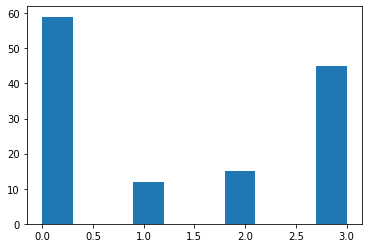

In [58]:
plt.hist(clinic_labels)

In [86]:
np.array(labels)[np.array(clinic_labels) == 3]

array(['50', '7', '18', '51', '42', '57', '4', '17', '26', '40', '23',
       '34', '32', '20', '14', '39', '21', '16', '82', '27', '49', '59',
       '60', '53', '45', '41', '8', '84', '44', '31', '28', '10', '52',
       '46', '22', '13', '30', '19', '11', '29', '38', '24', '1', '48',
       '35'], dtype='<U4')

In [81]:
# train,test = train_test_split(labels, test_size=4, random_state=33) # , stratify=clinic_labels

In [87]:
test = ['38', '24', '1', '48', 'n15', 'n11', 'n5', 'G414', 'G258', 'G324']
train = labels.copy()

for rs in test:
    if rs in train:
        train.remove(rs)

In [89]:
len(test), len(train)

(10, 121)

In [90]:
metadata = {'train':train,
            'test':test}
np.save('metadata/metadata_fcd.npy', metadata)

In [49]:
# for l in tqdm(labels):
#     try:
#         tensor = torch.load(os.path.join(tensors_root, f'tensor_{l}'))
#     except:
#         print(l)

In [24]:
# classes = ['n\d+', 'G\d+']
# labels_nG = []
# for c in classes:
#     labels_nG += list(filter(lambda x: len(re.findall(c, x)) > 0, labels))    

In [25]:
train,test = train_test_split(labels_nG, test_size=4, random_state=42)

In [30]:
metadata = {'train':train,
            'test':test}

In [31]:
np.save('metadata/metadata_fcd_nG.npy', metadata)

In [32]:
len(metadata['train'])

82